# Setup modules and google drive

In [1]:
# -*- coding: utf-8 -*-
"""
Created on 1/27/20
@author: Michael Choi

* grabbing FAANG OHLCV data and running time series modeling.
"""

#mount local Google drive
from google.colab import drive
drive.mount('/content/gdrive')

from datetime import datetime
import time
import re
import sys
import pandas as pd
import matplotlib.pyplot as plt
import fbprophet

#In case we switch to quandl data source
#quandl is not part of the base co-lab build
!pip install quandl
import quandl

#for now use this to get latest yahoo prices
!pip install yahoo-historical
#https://github.com/AndrewRPorter/yahoo-historical

from yahoo_historical import Fetcher


#Update path to import from "Finance-NLP-master" directory in My Drive
sys.path.append('/content/gdrive/My Drive/Finance-NLP-master')


import oauth_info as auth # our local file with the OAuth infos

#you need to specify your own Quandl api key in the oauth_info.py document as QUANDL_KEY
quandl.ApiConfig.api_key = auth.QUANDL_KEY

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Importing the data

##Quandl Data source

In [2]:
# Retrieve TSLA data from Quandl
aapl_df1 = quandl.get('WIKI/AAPL')

# Retrieve the GM data from Quandl
goog_df1 = quandl.get('WIKI/GOOG')
goog_df1.tail(5)


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,1092.74,1106.30,1085.15,1090.88,1640709.0,0.0,1.0,1092.74,1106.30,1085.15,1090.88,1640709.0
2018-03-22,1081.88,1082.90,1045.91,1049.08,2580374.0,0.0,1.0,1081.88,1082.90,1045.91,1049.08,2580374.0
2018-03-23,1047.03,1063.36,1021.22,1021.57,2113497.0,0.0,1.0,1047.03,1063.36,1021.22,1021.57,2113497.0
2018-03-26,1046.00,1055.63,1008.40,1053.21,2558385.0,0.0,1.0,1046.00,1055.63,1008.40,1053.21,2558385.0
2018-03-27,1063.00,1064.84,996.92,1005.10,3029471.0,0.0,1.0,1063.00,1064.84,996.92,1005.10,3029471.0


##Yahoo data source

In [3]:

ticker_fb = Fetcher("FB", [2015,1,1])
fb_df=ticker_fb.get_historical()
print(fb_df)

ticker_aapl = Fetcher("AAPL", [2015,1,1])
aapl_df=ticker_aapl.get_historical()
print(aapl_df)

ticker_amzn = Fetcher("AMZN", [2015,1,1])
amzn_df=ticker_amzn.get_historical()
print(amzn_df)

ticker_nflx = Fetcher("NFLX", [2015,1,1])
nflx_df=ticker_nflx.get_historical()
print(nflx_df)

ticker_googl = Fetcher("GOOGL", [2015,1,1])
googl_df=ticker_googl.get_historical()
print(googl_df)

            Date        Open        High  ...       Close   Adj Close    Volume
0     2015-01-02   78.580002   78.930000  ...   78.449997   78.449997  18177500
1     2015-01-05   77.980003   79.250000  ...   77.190002   77.190002  26452200
2     2015-01-06   77.230003   77.589996  ...   76.150002   76.150002  27399300
3     2015-01-07   76.760002   77.360001  ...   76.150002   76.150002  22045300
4     2015-01-08   76.739998   78.230003  ...   78.180000   78.180000  23961000
...          ...         ...         ...  ...         ...         ...       ...
1272  2020-01-23  220.750000  221.490005  ...  219.759995  219.759995  11195000
1273  2020-01-24  220.800003  221.779999  ...  217.940002  217.940002  11905800
1274  2020-01-27  213.100006  216.059998  ...  214.869995  214.869995  13810700
1275  2020-01-28  216.139999  218.740005  ...  217.789993  217.789993  13369200
1276  2020-01-29  221.440002  224.199997  ...  223.229996  223.229996  24971241

[1277 rows x 7 columns]
            Dat

#EDA

##FAANG Historical Adjusted Close Prices

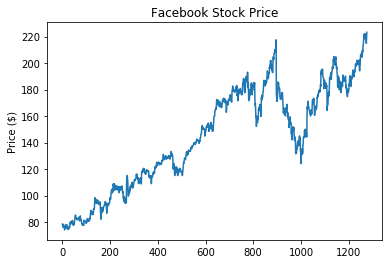

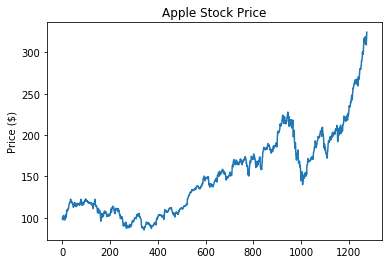

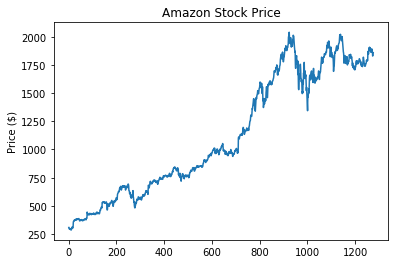

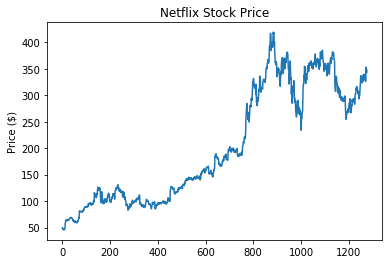

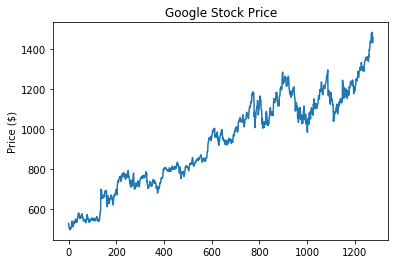

In [4]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(fb_df.index, fb_df['Adj Close'])
plt.title('Facebook Stock Price')
plt.ylabel('Price ($)');
plt.show()
plt.plot(aapl_df.index, aapl_df['Adj Close'])
plt.title('Apple Stock Price')
plt.ylabel('Price ($)');
plt.show()
plt.plot(amzn_df.index, amzn_df['Adj Close'])
plt.title('Amazon Stock Price')
plt.ylabel('Price ($)');
plt.show()
plt.plot(nflx_df.index, nflx_df['Adj Close'])
plt.title('Netflix Stock Price')
plt.ylabel('Price ($)');
plt.show()
plt.plot(googl_df.index, googl_df['Adj Close'])
plt.title('Google Stock Price')
plt.ylabel('Price ($)');
plt.show()

##Market Capitalization equalization
We try to compare apples to apples amongst the FAANG stocks by including outstanding share numbers to put stock prices into context and even out any splits.
Possible investment strategy may be to weight assets across FAANG stocks differently based on social media news.  So imagine a new FAANG ETF that changed weighting based on social media sentiment.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


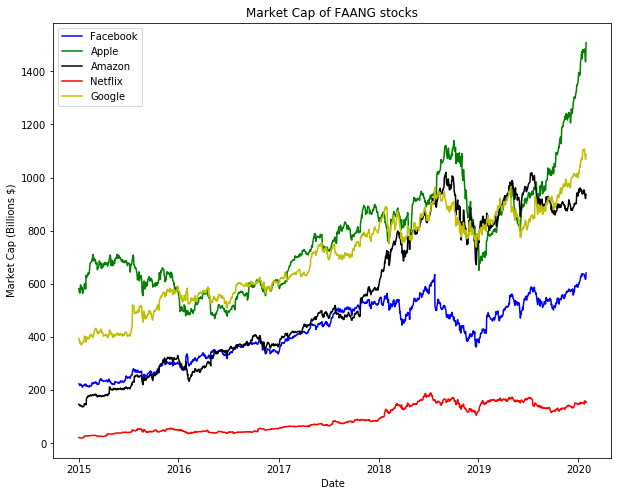

In [5]:
#data from https://www.macrotrends.net/stocks/charts/AAPL/apple/shares-outstanding
fb_shares = {2020: 2873e6, 2019: 2873e6, 2018: 2921e6, 2017: 2956e6, 2016: 2925e6, 2015: 2853e6, 2014: 2664e6}
appl_shares = {2020: 4649e6, 2019: 4649e6, 2018: 5000e6, 2017: 5252e6, 2016: 5500e6, 2015: 5793e6, 2014: 6123e6}
amzn_shares = {2020: 504e6, 2019: 504e6, 2018: 500e6, 2017: 493e6, 2016: 484e6, 2015: 477e6, 2014: 462e6}
nflx_shares = {2020: 452e6, 2019: 452e6, 2018: 451e6, 2017: 447e6, 2016: 439e6, 2015: 436e6, 2014: 432e6}
googl_shares = {2020: 746e6, 2019: 746e6, 2018: 750e6, 2017: 751e6, 2016: 748e6, 2015: 745e6, 2014: 742e6}


#extract the year from each stock df's date index then take the dates from the index and move the data to a date column
fb_df.index = pd.to_datetime(fb_df.index)
fb_df['Date'] = pd.to_datetime(fb_df['Date'], errors='coerce')
fb_df['Year'] = fb_df['Date'].dt.year
#fb_df.reset_index(level=0, inplace = True)
fb_df['cap'] = 0

aapl_df.index = pd.to_datetime(aapl_df.index)
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'], errors='coerce')
aapl_df['Year'] = aapl_df['Date'].dt.year
#aapl_df.reset_index(level=0, inplace = True)
aapl_df['cap'] = 0

amzn_df.index = pd.to_datetime(amzn_df.index)
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'], errors='coerce')
amzn_df['Year'] = amzn_df['Date'].dt.year
amzn_df.reset_index(level=0, inplace = True)
amzn_df['cap'] = 0

nflx_df.index = pd.to_datetime(nflx_df.index)
nflx_df['Date'] = pd.to_datetime(nflx_df['Date'], errors='coerce')
nflx_df['Year'] = nflx_df['Date'].dt.year
#nflx_df.reset_index(level=0, inplace = True)
nflx_df['cap'] = 0

googl_df.index = pd.to_datetime(googl_df.index)
googl_df['Date'] = pd.to_datetime(googl_df['Date'], errors='coerce')
googl_df['Year'] = googl_df['Date'].dt.year
#googl_df.reset_index(level=0, inplace = True)
googl_df['cap'] = 0

#Now update the market cap for all data
for i, year in enumerate(fb_df['Year']):
  # Retrieve the shares for the year
  shares = fb_shares.get(year)

  # Update the cap column to shares times the price
  fb_df.loc[i, 'cap'] = shares * fb_df.loc[i, 'Adj Close']

for i, year in enumerate(aapl_df['Year']):
  # Retrieve the shares for the year
  shares = appl_shares.get(year)

  # Update the cap column to shares times the price
  aapl_df.loc[i, 'cap'] = shares * aapl_df.loc[i, 'Adj Close']

for i, year in enumerate(amzn_df['Year']):
  # Retrieve the shares for the year
  shares = amzn_shares.get(year)

  # Update the cap column to shares times the price
  amzn_df.loc[i, 'cap'] = shares * amzn_df.loc[i, 'Adj Close']

for i, year in enumerate(nflx_df['Year']):
  # Retrieve the shares for the year
  shares = nflx_shares.get(year)

  # Update the cap column to shares times the price
  nflx_df.loc[i, 'cap'] = shares * nflx_df.loc[i, 'Adj Close']

for i, year in enumerate(googl_df['Year']):
  # Retrieve the shares for the year
  shares = googl_shares.get(year)

  # Update the cap column to shares times the price
  googl_df.loc[i, 'cap'] = shares * googl_df.loc[i, 'Adj Close']

fb_df.rename(columns={'Open': 'fb_open', 'High': 'fb_high', 'Low': 'fb_low', 'Close': 'fb_close', 'Adj Close': 'fb_adj_close', 'Volume': 'fb_vol', 'cap': 'fb_cap'}, inplace=True)
aapl_df.rename(columns={'Open': 'aapl_open', 'High': 'aapl_high', 'Low': 'aapl_low', 'Close': 'aapl_close', 'Adj Close': 'aapl_adj_close', 'Volume': 'aapl_vol', 'cap': 'aapl_cap'}, inplace=True)
amzn_df.rename(columns={'Open': 'amzn_open', 'High': 'amzn_high', 'Low': 'amzn_low', 'Close': 'amzn_close', 'Adj Close': 'amzn_adj_close', 'Volume': 'amzn_vol', 'cap': 'amzn_cap'}, inplace=True)
nflx_df.rename(columns={'Open': 'nflx_open', 'High': 'nflx_high', 'Low': 'nflx_low', 'Close': 'nflx_close', 'Adj Close': 'nflx_adj_close', 'Volume': 'nflx_vol', 'cap': 'nflx_cap'}, inplace=True)
googl_df.rename(columns={'Open': 'googl_open', 'High': 'googl_high', 'Low': 'googl_low', 'Close': 'googl_close', 'Adj Close': 'googl_adj_close', 'Volume': 'googl_vol', 'cap': 'googl_cap'}, inplace=True)

del fb_df['Year']
del aapl_df['Year']
del amzn_df['Year']
del nflx_df['Year']
del googl_df['Year']

faang_df = fb_df.merge(aapl_df, how='inner', on='Date')
faang_df = faang_df.merge(amzn_df, how='inner', on='Date')
faang_df = faang_df.merge(nflx_df, how='inner', on='Date')
faang_df = faang_df.merge(googl_df, how='inner', on='Date')

# Select only the relevant columns
faang_cap = faang_df.loc[:, ['Date', 'fb_cap', 'aapl_cap', 'amzn_cap', 'nflx_cap', 'googl_cap']]

# For sanity, divide to get market cap in billions of dollars
faang_cap['fb_cap'] = faang_cap['fb_cap'] / 1e9
faang_cap['aapl_cap'] = faang_cap['aapl_cap'] / 1e9
faang_cap['amzn_cap'] = faang_cap['amzn_cap'] / 1e9
faang_cap['nflx_cap'] = faang_cap['nflx_cap'] / 1e9
faang_cap['googl_cap'] = faang_cap['googl_cap'] / 1e9

plt.figure(figsize=(10, 8))
plt.plot(faang_cap['Date'], faang_cap['fb_cap'], 'b-', label = 'Facebook')
plt.plot(faang_cap['Date'], faang_cap['aapl_cap'], 'g-', label = 'Apple')
plt.plot(faang_cap['Date'], faang_cap['amzn_cap'], 'k-', label = 'Amazon')
plt.plot(faang_cap['Date'], faang_cap['nflx_cap'], 'r-', label = 'Netflix')
plt.plot(faang_cap['Date'], faang_cap['googl_cap'], 'y-', label = 'Google')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of FAANG stocks')
plt.legend();

#MAIN

##Modeling

###Prophet (FB package)

In [13]:
#prophet runs on the date column named 'ds' and date as 'y' so we morph our FAANG dfs accordingly
fb_prophet_df = fb_df.rename(columns={'Date': 'ds', 'fb_cap': 'y'})
aapl_prophet_df = aapl_df.rename(columns={'Date': 'ds', 'aapl_cap': 'y'})
amzn_prophet_df = amzn_df.rename(columns={'Date': 'ds', 'amzn_cap': 'y'})
nflx_prophet_df = nflx_df.rename(columns={'Date': 'ds', 'nflx_cap': 'y'})
googl_prophet_df = googl_df.rename(columns={'Date': 'ds', 'googl_cap': 'y'})

# Put market cap in billions
fb_prophet_df['y'] = fb_prophet_df['y'] / 1e9
aapl_prophet_df['y'] = aapl_prophet_df['y'] / 1e9
amzn_prophet_df['y'] = amzn_prophet_df['y'] / 1e9
nflx_prophet_df['y'] = nflx_prophet_df['y'] / 1e9
googl_prophet_df['y'] = googl_prophet_df['y'] / 1e9

# Make the prophet model and fit on the data
CHANGEPOINT_VAL = 0.15

fb_prophet = fbprophet.Prophet(changepoint_prior_scale=CHANGEPOINT_VAL)
fb_prophet.fit(fb_prophet_df)

aapl_prophet = fbprophet.Prophet(changepoint_prior_scale=CHANGEPOINT_VAL)
aapl_prophet.fit(aapl_prophet_df)

amzn_prophet = fbprophet.Prophet(changepoint_prior_scale=CHANGEPOINT_VAL)
amzn_prophet.fit(amzn_prophet_df)

nflx_prophet = fbprophet.Prophet(changepoint_prior_scale=CHANGEPOINT_VAL)
nflx_prophet.fit(nflx_prophet_df)

googl_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
googl_prophet.fit(googl_prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


####Prophet predictions

In [0]:
# Make a future dataframe for 1 year & make predictions
fb_forecast = fb_prophet.make_future_dataframe(periods=365, freq='D')
fb_forecast = fb_prophet.predict(fb_forecast)

aapl_forecast = aapl_prophet.make_future_dataframe(periods=365, freq='D')
aapl_forecast = aapl_prophet.predict(aapl_forecast)

amzn_forecast = amzn_prophet.make_future_dataframe(periods=365, freq='D')
amzn_forecast = amzn_prophet.predict(amzn_forecast)

nflx_forecast = nflx_prophet.make_future_dataframe(periods=365, freq='D')
nflx_forecast = nflx_prophet.predict(nflx_forecast)

googl_forecast = googl_prophet.make_future_dataframe(periods=365, freq='D')
googl_forecast = googl_prophet.predict(googl_forecast)

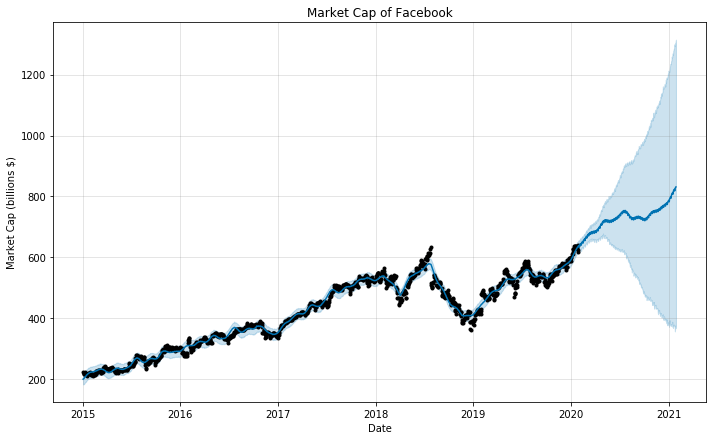

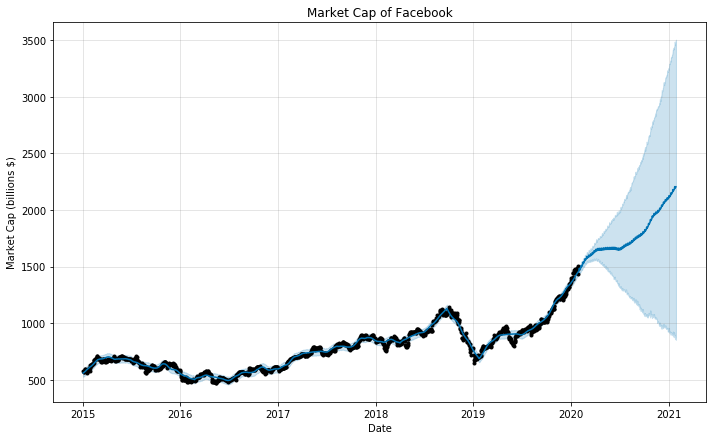

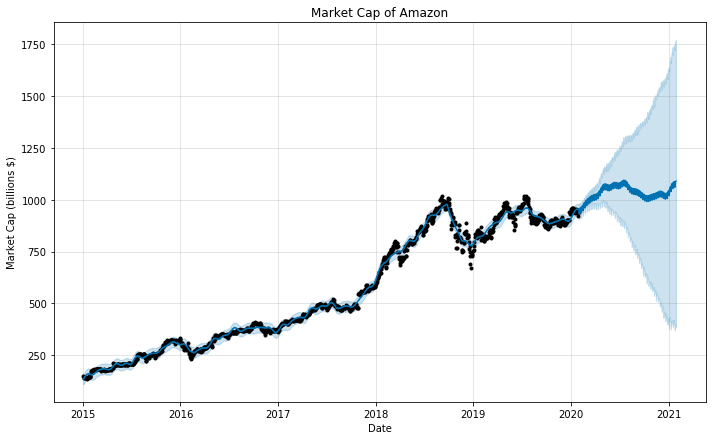

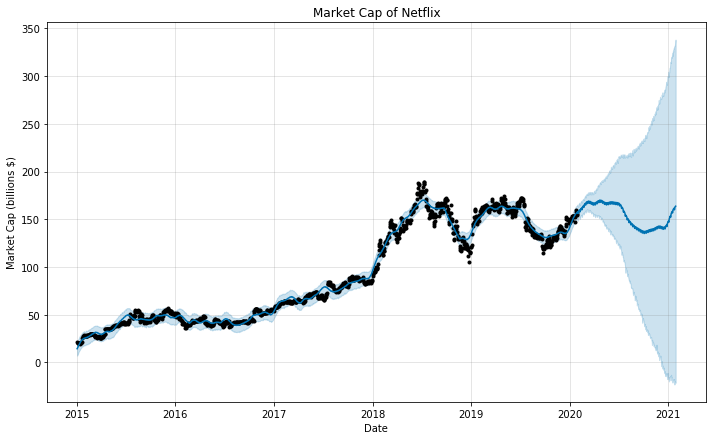

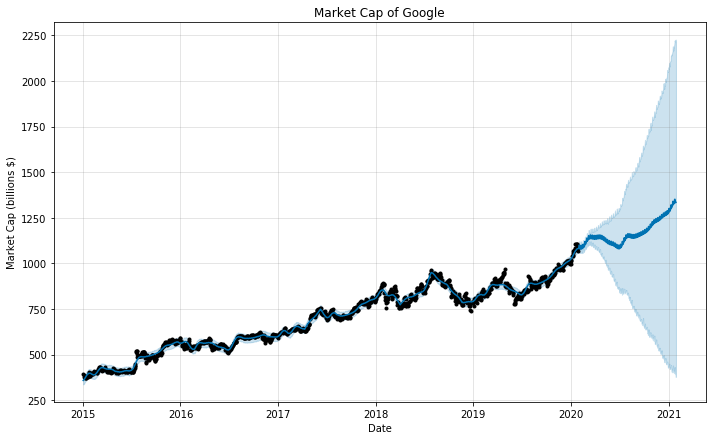

In [16]:
fb_prophet.plot(fb_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Facebook');

aapl_prophet.plot(aapl_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Facebook');

amzn_prophet.plot(amzn_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Amazon');

nflx_prophet.plot(nflx_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Netflix');

googl_prophet.plot(googl_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Google');

####Prophet's Important growth rate change Dates

In [23]:
print('Facebook Modeling Recent Important Dates')
print(fb_prophet.changepoints[10:])
print()
print('Apple Modeling Recent Important Dates')
print(aapl_prophet.changepoints[10:])
print()
print('Amazon Modeling Recent Important Dates')
print(amzn_prophet.changepoints[10:])
print()
print('Netflix Modeling Recent Important Dates')
print(nflx_prophet.changepoints[10:])
print()
print('Google Modeling Recent Important Dates')
print(googl_prophet.changepoints[10:])
print()

Facebook Modeling Recent Important Dates
449    2016-10-13
490    2016-12-12
530    2017-02-09
571    2017-04-10
612    2017-06-08
653    2017-08-07
694    2017-10-04
734    2017-11-30
775    2018-01-31
816    2018-04-02
857    2018-05-30
898    2018-07-27
938    2018-09-24
979    2018-11-20
1020   2019-01-23
Name: ds, dtype: datetime64[ns]

Apple Modeling Recent Important Dates
449    2016-10-13
490    2016-12-12
530    2017-02-09
571    2017-04-10
612    2017-06-08
653    2017-08-07
694    2017-10-04
734    2017-11-30
775    2018-01-31
816    2018-04-02
857    2018-05-30
898    2018-07-27
938    2018-09-24
979    2018-11-20
1020   2019-01-23
Name: ds, dtype: datetime64[ns]

Amazon Modeling Recent Important Dates
449    2016-10-13
490    2016-12-12
530    2017-02-09
571    2017-04-10
612    2017-06-08
653    2017-08-07
694    2017-10-04
734    2017-11-30
775    2018-01-31
816    2018-04-02
857    2018-05-30
898    2018-07-27
938    2018-09-24
979    2018-11-20
1020   2019-01-23
Name: 

,Date,fb_open,fb_high,fb_low,fb_close,fb_adj_close,fb_vol,fb_cap
1970-01-01 00:00:00.000000000,2015-01-02,78.580002,78.930000,77.699997,78.449997,78.449997,18177500,2.238178e+11
1970-01-01 00:00:00.000000001,2015-01-05,77.980003,79.250000,76.860001,77.190002,77.190002,26452200,2.202231e+11
1970-01-01 00:00:00.000000002,2015-01-06,77.230003,77.589996,75.360001,76.150002,76.150002,27399300,2.172560e+11
1970-01-01 00:00:00.000000003,2015-01-07,76.760002,77.360001,75.820000,76.150002,76.150002,22045300,2.172560e+11
1970-01-01 00:00:00.000000004,2015-01-08,76.739998,78.230003,76.080002,78.180000,78.180000,23961000,2.230475e+11
...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000001272,2020-01-23,220.750000,221.490005,219.270004,219.759995,219.759995,11195000,6.313705e+11
1970-01-01 00:00:00.000001273,2020-01-24,220.800003,221.779999,216.110001,217.940002,217.940002,11905800,6.261416e+11
1970-01-01 00:00:00.000001274,2020-01-27,213.100006,216.059998,212.500000,214.869995,214.869995,13810700,6.173215e+11
1970-01-01 00:00:00.000001275,2020-01-28,216.139999,218.740005,213.520004,217.789993,217.789993,13369200,6.257106e+11
